In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
from pytorch_eo.datasets.land_cover_net import LandCoverNet
from pytorch_eo.utils.sensors import S2

bands = [S2.red, S2.green, S2.blue]

ds = LandCoverNet(
    path="./data/LandCoverNet", 
    batch_size=9, 
    bands=bands, 
    verbose=True
)

ds.setup()

training samples 28512
validation samples 9504
test samples 9504


In [12]:
ds.df

,image,mask
0,data/LandCoverNet/ref_landcovernet_v1_source/r...,data/LandCoverNet/ref_landcovernet_v1_labels/r...
1,data/LandCoverNet/ref_landcovernet_v1_source/r...,data/LandCoverNet/ref_landcovernet_v1_labels/r...
2,data/LandCoverNet/ref_landcovernet_v1_source/r...,data/LandCoverNet/ref_landcovernet_v1_labels/r...
3,data/LandCoverNet/ref_landcovernet_v1_source/r...,data/LandCoverNet/ref_landcovernet_v1_labels/r...
4,data/LandCoverNet/ref_landcovernet_v1_source/r...,data/LandCoverNet/ref_landcovernet_v1_labels/r...
...,...,...
47515,data/LandCoverNet/ref_landcovernet_v1_source/r...,data/LandCoverNet/ref_landcovernet_v1_labels/r...
47516,data/LandCoverNet/ref_landcovernet_v1_source/r...,data/LandCoverNet/ref_landcovernet_v1_labels/r...
47517,data/LandCoverNet/ref_landcovernet_v1_source/r...,data/LandCoverNet/ref_landcovernet_v1_labels/r...
47518,data/LandCoverNet/ref_landcovernet_v1_source/r...,data/LandCoverNet/ref_landcovernet_v1_labels/r...


In [13]:
ds.classes

[{'name': 'other', 'color': '#000000'},
 {'name': 'water', 'color': '#0000ff'},
 {'name': 'artificial-bare-ground', 'color': '#888888'},
 {'name': 'natural-bare-ground', 'color': '#d1a46d'},
 {'name': 'permanent-snow-ice', 'color': '#f5f5ff'},
 {'name': 'cultivated-vegetation', 'color': '#d64c2b'},
 {'name': 'permanent-snow-and-ice', 'color': '#186818'},
 {'name': 'semi-natural-vegetation', 'color': '#00ff00'}]

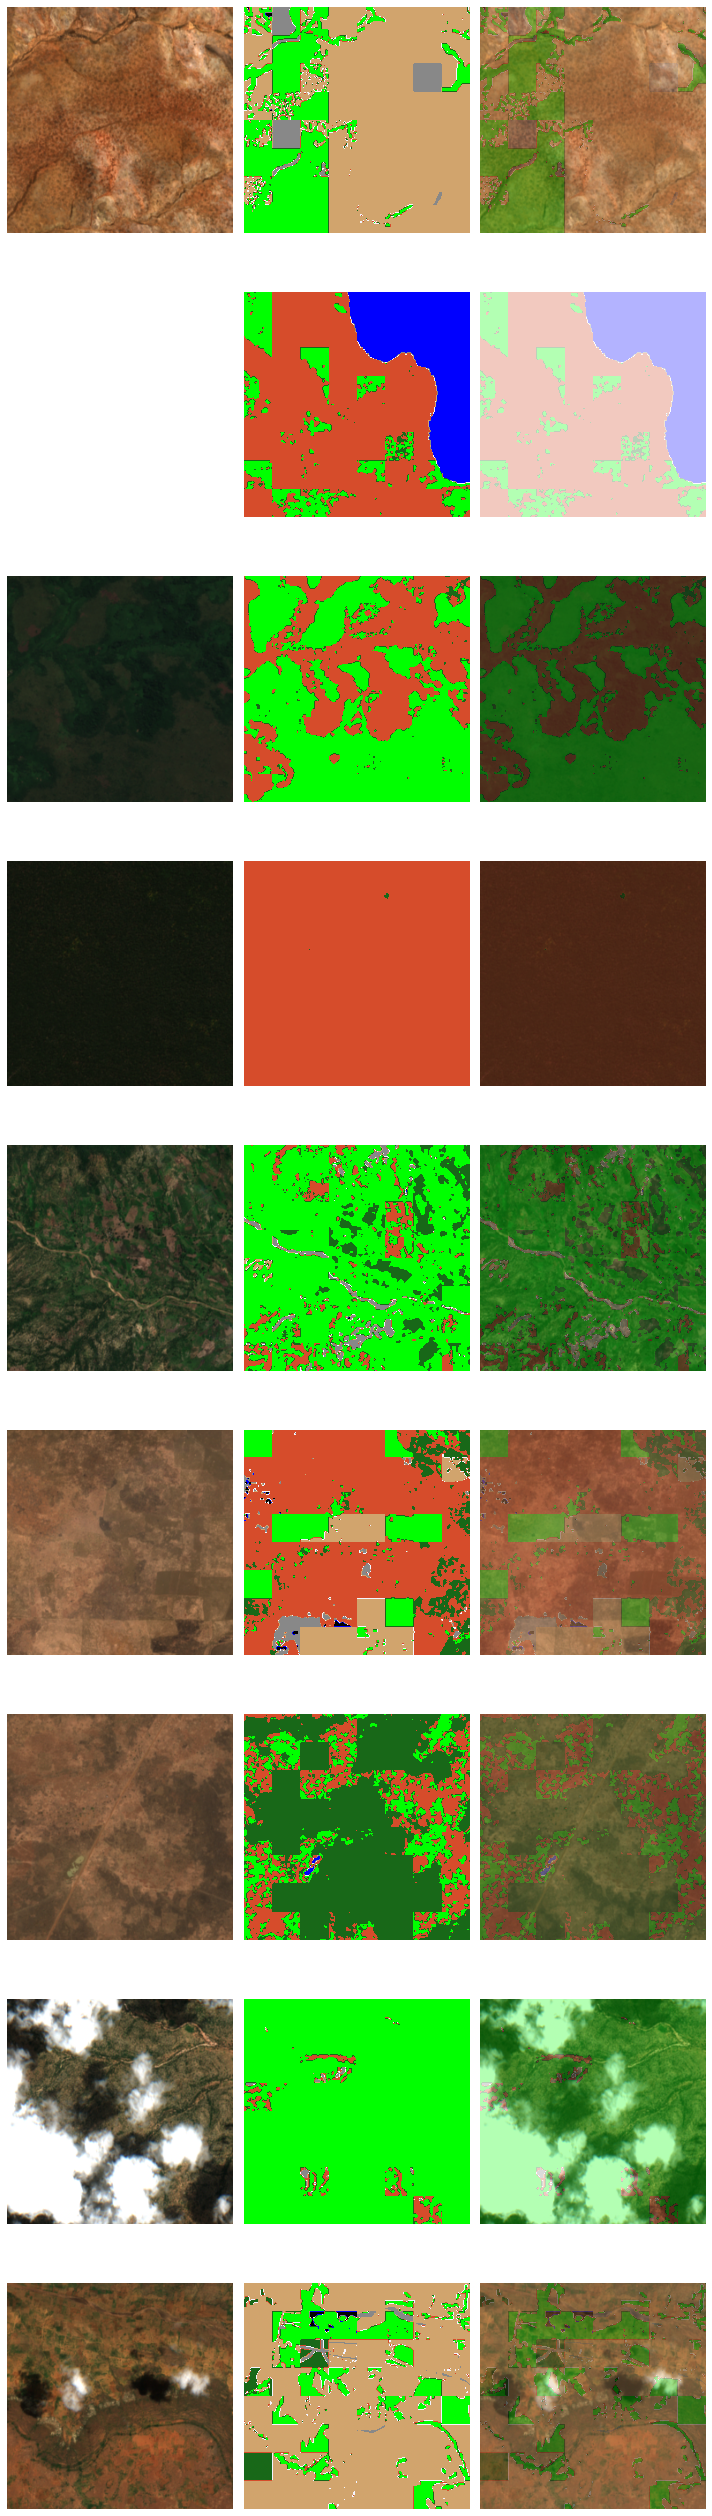

In [14]:
import matplotlib.pyplot as plt
import matplotlib
import torch 
import numpy as np
from pytorch_eo.utils.image import to_uint8

colors = [label['color'] for label in ds.classes]
cmap = matplotlib.colors.ListedColormap(colors)
boundaries = np.arange(-0.5, len(colors) + 0.5, 1)
norm = matplotlib.colors.BoundaryNorm(boundaries, cmap.N)

imgs, masks = next(iter(ds.train_dataloader()))

fig = plt.figure(figsize=(10, len(imgs)*4))
th = 4000
for i, (img, mask) in enumerate(zip(imgs, masks)):
    img = to_uint8(img, 0, th)
    ax = plt.subplot(len(imgs), 3, 3*i + 1)
    ax.imshow(img)
    ax.axis('off')
    ax = plt.subplot(len(imgs), 3, 3*i + 2)
    mask = np.argmax(mask, axis=0)
    ax.imshow(mask, cmap=cmap, norm=norm)
    ax.axis('off')
    ax = plt.subplot(len(imgs), 3, 3*i + 3)
    ax.imshow(img)
    ax.imshow(mask, cmap=cmap, norm=norm, alpha=0.3)
    #ax.imshow(mask)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
from pytorch_eo.tasks.segmentation import ImageSegmentation
import segmentation_models_pytorch as smp
from einops import rearrange
import torch

class Model(torch.nn.Module):

	def __init__(self, in_chans, num_classes, max_value=4000):
		super().__init__()
		self.model = smp.Unet(
			encoder_name='resnet18',
			encoder_weights='imagenet',
			in_channels=in_chans,
			classes=num_classes,
		)
		self.max_value = max_value

	def forward(self, x):
		x = rearrange(x, 'b h w c -> b c h w')
		x = x / self.max_value
		return self.model(x)

model = Model(in_chans=len(bands), num_classes=ds.num_classes)

task = ImageSegmentation(model)

out = task(imgs)

out.shape, out.dtype

(torch.Size([9, 8, 256, 256]), torch.float32)

In [7]:
import pytorch_lightning as pl

ds = LandCoverNet(
    path="./data/LandCoverNet", 
    batch_size=128, 
    bands=[S2.red, S2.green, S2.blue],
    num_workers=20,
    pin_memory=True,
)

model = Model(in_chans=len(bands), num_classes=ds.num_classes)

hparams = {
    'loss': 'BCEWithLogitsLoss',
    'optimizer': 'Adam',
    'optim_params': {
        'lr': 3e-4
    }
}

task = ImageSegmentation(model, hparams)

In [8]:
trainer = pl.Trainer(
    gpus=1,
    precision=16,
    max_epochs=10,
)

trainer.fit(task, ds)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | Model             | 14.3 M
1 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
57.317    Total estimated model params size (MB)


/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:610: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  warning_cache.deprecation(


In [9]:
trainer.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_iou': 0.6414701342582703, 'test_loss': 0.10829468071460724}
--------------------------------------------------------------------------------


[{'test_iou': 0.6414701342582703, 'test_loss': 0.10829468071460724}]

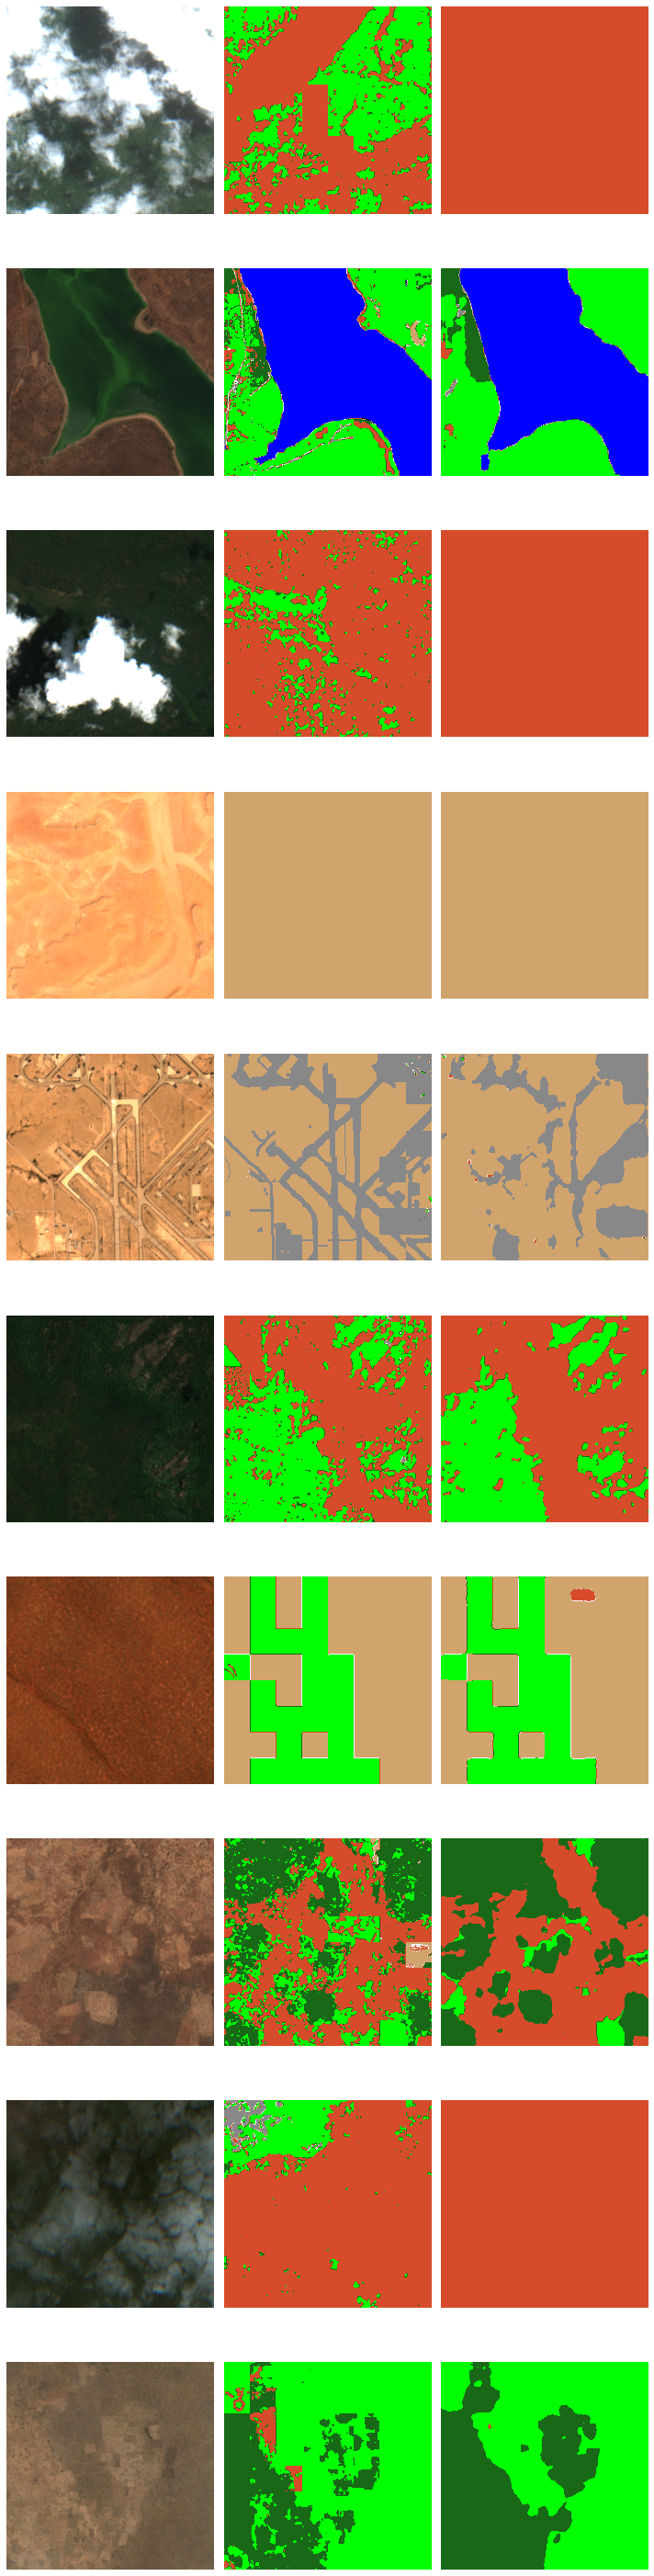

In [22]:
imgs, masks = next(iter(ds.test_dataloader(shuffle=True, batch_size=10)))

preds = task.predict(imgs)
preds = torch.argmax(preds, axis=1)

fig = plt.figure(figsize=(10, len(imgs)*4))
for i, (img, mask, pred) in enumerate(zip(imgs, masks, preds)):    
    img = to_uint8(img, 0, th)
    ax = plt.subplot(len(imgs), 3, 3*i + 1)
    ax.imshow(img) 
    ax.axis('off')
    ax = plt.subplot(len(imgs), 3, 3*i + 2)
    mask = torch.argmax(mask, axis=0)
    ax.imshow(mask, cmap=cmap, norm=norm)
    ax.axis('off')
    ax = plt.subplot(len(imgs), 3, 3*i + 3)
    ax.imshow(pred, cmap=cmap, norm=norm)
    ax.axis('off')
plt.tight_layout()
plt.show()